**Table of contents**<a id='toc0_'></a>    
- [Обработка данных и Topic Modeling](#toc1_)    
  - [Импорт библиотек](#toc1_1_)    
  - [Профили](#toc1_2_)    
  - [Посты](#toc1_3_)    
  - [Реакции](#toc1_4_)    
  - [Обработка данных](#toc1_5_)    
  - [Лемманизация текста](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Обработка данных и Topic Modeling](#toc0_)

## <a id='toc1_1_'></a>[Импорт библиотек](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import json
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from  pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
from ast import literal_eval

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Зададим random_state

In [4]:
SEED =42

## <a id='toc1_2_'></a>[Профили](#toc0_)

In [5]:
profiles_main = pd.read_json('total_profiles.json', orient='index')
print(profiles_main.shape)
profiles_main.head()

(199, 8)


,name,city,connections,role,company,experience,employment_type,skills
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,..."
kirill-gonin,Kirill Gonin,Russia,180,Full Stack Developer JavaScript,«Сервисный центр Транстелематика»,2.75,Full-time,"[React, Jest, Material-UI, Express, CSS, HTML,..."
alexey-sergienko,Alexey Sergienko,Moscow,168,Software Developer,OZON.ru,9.83,Full-time,"[Электроника, Git, Vue.js, HTML, electron , Re..."


In [6]:
profiles_add = pd.read_json('profiles_developer_kristina_86.json', orient='index')
print(profiles_add.shape)
profiles_add.head(3)

(86, 8)


,name,city,connections,role,company,experience,employment_type,skills
anastasiia-miagkikh-b118a2168,Anastasiia Miagkikh,St Petersburg,138,Frontend Developer,Северсталь-Инфоком,4.08,Full-time,"[Photoshop, JavaScript, Redux, Matlab, React]"
mirkadev,Vladimir Mironov,Mordovia,132,Middle NodeJS Developer (backend only),SimbirSoft,4.58,unknown,"[Socket.IO, Koa.js, JavaScript, PostgreSQL, Mo..."
elena-vidyakina-2b877990,Elena Vidyakina,Russia,61,Senior backend developer,Yandex Eats,12.50,unknown,"[Angular, .NET, Unit Testing, C#, PowerDesigne..."


In [7]:
profiles_senior = pd.read_json('profiles_developer_senior.json', orient='index')
print(profiles_senior.shape)
profiles_senior.head(3)

(86, 8)


,name,city,connections,role,company,experience,employment_type,skills
silvansky,Valentine Silvansky,Moscow,307,Senior Developer,Songsterr,15.83,unknown,"[JavaScript, Subversion, Carbon, Objective-C, ..."
vyacheslav-kruglov-2279421a5,Vyacheslav Kruglov,Russia,109,Senior Golang Developer,Yandex,4.50,Full-time,"[SQL, Golang , go, Git]"
denis-k-0a44327b,Denis K.,Moscow,500+,Senior Golang Developer,KASPERSKY LABS LIMITED,5.50,Full-time,"[docker, API Gateways, Google API, Hyperledger..."


Объединим датафреймы

In [8]:
profiles = pd.concat([profiles_main, profiles_add, profiles_senior])
print(profiles.shape)

(371, 8)


## <a id='toc1_3_'></a>[Посты](#toc0_)

In [9]:
posts_main = pd.read_json('total_posts.json', orient='index')
posts_main.head(3)

,0,1,2,3,4,5,6,7,8,9
nurlan-isbulaev-34bb211a3,"🔥 11 сервисов на базе ИИ ,которые помогут прок...",🔥 Если вы в поисках удаленной работы или допол...,Как Ваш профиль LinkedIn виден со стороны рекр...,"🎯 𝗦𝗤𝗟 𝗭𝗲𝗿𝗼 𝘁𝗼 𝗛𝗲𝗿𝗼 Notes 𝘄𝗶𝘁𝗵 𝗠𝗶𝗻𝗱𝗺𝗮𝗽 📚SQL, or...",Rest API and HTTP notes.A REST API (Representa...,Best ChatGPT Alternatives to finish hours of w...,Землетрясения напомнили кто мы Мы все маленьк...,С момента начала моей работы в компании Доброз...,None,None
maria-terenteva,None,None,None,None,None,None,None,None,None,None
руслан-гусейнов-091858186,None,None,None,None,None,None,None,None,None,None


In [10]:
posts_add = pd.read_json('posts_developer_kristina_86.json', orient='index')
posts_add.head(3)

,0,1,2,3,4,5,6,7,8,9
anastasiia-miagkikh-b118a2168,None,None,None,None,None,None,None,None,None,None
mirkadev,I've broken a new record for touch typing (onl...,None,None,None,None,None,None,None,None,None
elena-vidyakina-2b877990,None,None,None,None,None,None,None,None,None,None


In [11]:
posts_senior = pd.read_json('posts_developer_senior.json', orient='index')
posts_senior.head(3)

,0,1,2,3,4,5
silvansky,None,None,None,None,None,None
vyacheslav-kruglov-2279421a5,None,None,None,None,None,None
denis-k-0a44327b,None,None,None,None,None,None


Объединим датафреймы

In [12]:
posts = pd.concat([posts_main, posts_add, posts_senior])
print(posts.shape)

(371, 10)


## <a id='toc1_4_'></a>[Реакции](#toc0_)

In [13]:
reactions_main = pd.read_json('total_reactions.json', orient='index')
reactions_main.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
nurlan-isbulaev-34bb211a3,"🔥 11 сервисов на базе ИИ ,которые помогут прок...",#opentowork #recruiter Всем привет! Приступаю ...,🔥 Если вы в поисках удаленной работы или допол...,Буду благодарна за репосты и лайки:),Simple example ✌️Backend - APIs - Frontend 🔥 F...,My biggest problem :),#chatgpt,(Обычный профессионал - VS - АйТи профессионал),JavaScript Array Methods CheatSheet 📍This will...,"Клянусь, с сегоняшним наймом, создаётся впечат...",...,None,None,None,None,None,None,None,None,None,None
maria-terenteva,Me being a parent:,Всем привет!Активно ищу работу/стажировку/подр...,#it #humor #memes,Всем привет 👋Linkedln сообщество сейчас активн...,"Ok, Google, сливаю суть: #BardAI сейчас исполь...","Новые сотрудники, GameMod ищет вас 👀 Возвращаю...",Hi everyone - I am looking for a new role and ...,"❗ТОП-15 ❗ РЕСУРСОВ, КОТОРЫЕ МОГУТ ПОМОЧЬ НЕ ТО...",🍃 Specialize in MongoDB to build your applicat...,Life is not a fair game 🥺 That is exactly how ...,...,"The more you know, the more you know that you ...",Loving these AI generated pictures of the Coro...,Employers wants young candidates with deep exp...,When I interviewed someone and their laptop......,https://lnkd.in/guxNaeUc#Smart,https://lnkd.in/g-StFrjNSome lovely vintage in...,None,None,None,None
руслан-гусейнов-091858186,#humor #it,"Я #нанимаю. Знаете людей, которых это может за...",This story is about my path to IT.I had some t...,Напомню один из основополагающих принципов наш...,"А у вас как дела, цсс инженеры и хтмл архитект...","Здравствуйте, я в поиске новой карьерной возмо...",Mama I made it #google .... first day at work,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
reactions_add = pd.read_json('reactions_developer_kristina_86.json', orient='index')
reactions_add.head(3)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
anastasiia-miagkikh-b118a2168,Houdini ocean#oceanstorm #houdini,My new employee asked me one day for time off....,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
mirkadev,If you meet me you'll see that I'm fast. At ev...,It's my first day of a new jobWish me good luck 🍀,"Здравствуйте, я в поиске новой карьерной возмо...","Не прошло и двадцати с лишним лет, как OZON.ru...",I am extremely happy and grateful to say that ...,Всем привет! Мой крёстный сегодня был вынужден...,We're thrilled to be back on the streets of La...,"Today, we’re thrilled to announce the latest a...",Open source technology is a critical part of o...,Our self-driving car first started operating o...,...,None,None,None,None,None,None,None,None,None,None
elena-vidyakina-2b877990,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [15]:
reactions_senior = pd.read_json('reactions_developer_senior.json', orient='index')
reactions_senior.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
silvansky,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
vyacheslav-kruglov-2279421a5,Привет!Меня зовут Максим Говоров. Вот уже 10 л...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
denis-k-0a44327b,Today I started a new job at Apple!☁️,Do you agree?,Progress 👍,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Объединим датафреймы

In [16]:
reactions = pd.concat([reactions_main, reactions_add, reactions_senior])
print(reactions.shape)

(371, 30)


## Выгрузка отфильтрованных данных

In [17]:
developer_df = pd.read_json('developer_profiles.json')
developer_df.head(3)

,name,city,connections,role,company,experience,employment_type,skills,reactions,posts
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д...","[Me being a parent:, Всем привет!Активно ищу р...","[None, None, None, None, None, None, None, Non..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,...","[#humor #it, Я #нанимаю. Знаете людей, которых...","[None, None, None, None, None, None, None, Non..."


In [18]:
developer_df['all_posts'] = developer_df['reactions'] + developer_df['posts']
developer_df.head(3)

,name,city,connections,role,company,experience,employment_type,skills,reactions,posts,all_posts
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д...","[Me being a parent:, Всем привет!Активно ищу р...","[None, None, None, None, None, None, None, Non...","[Me being a parent:, Всем привет!Активно ищу р..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,...","[#humor #it, Я #нанимаю. Знаете людей, которых...","[None, None, None, None, None, None, None, Non...","[#humor #it, Я #нанимаю. Знаете людей, которых..."


## <a id='toc1_5_'></a>[Обработка данных](#toc0_)

- Выгрузка релеввантных постов
- Очистка текстов 
- Лемманизация 
- TF-IDF и LDA

In [19]:
def clean_text(text):
    #import re при использовании pandarallel
    try:
        text = text.lower()
        text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
        text = re.sub('\d+', '', text) # удаляем все цифры
        
        text = re.sub('[^а-яА-Я\s]+' , '', text)
        text = re.sub('\s+', ' ', text) # заменяем множество пробелов одним пробелом
        
        text = text.strip() # удаляем пробелы в начале и конце текста
    except:
        pass
    return text

Объединим все тексты в один список

In [20]:
all_texts = np.concatenate(developer_df['all_posts'].values)

print(all_texts)
print(len(all_texts))

['🔥 11 сервисов на базе ИИ ,которые помогут прокачать твой профиль в LinkedIn🔥❗ Лучшая благодарность за мой труд - это ваши реакции и комментарии!🔥Буду благодарен за подписку на мои другие социальные сети:✔Instagram: instagram.com/ralkofood\xa0Там все о еде, обратная сторона работы ресторанов, рецепты, Food-обзоры, будет много контента о жизни в Польше и Европе в целоми т.д.✔Telegram: t.me/RalkoDenis\xa0Там дублирую весь контент из LinkedIn, что бы вам было удобней читать и ничего не пропускать.📌\xa0jasper.ai/\xa0ИИ-копирайтер. Поможет сгенерировать интересные статьи в LinkedIn\xa0#linkedin📌\xa0wonsulting.com/networkai\xa0Автоматизированный инструмент ИИ, который помогает пользователям быстро и эффективно расширить свою профессиональную сеть.📌\xa0sayhi.pro/\xa0Расширение Chrome на базе ИИ, которое помогает пользователям писать эффективные и убедительные сообщения LinkedIn, адаптированные к их получателям.📌\xa0linkoai.com/\xa0Инструмент на основе ИИ, который помогает людям максимально и

Уберем дубликаты с помощью множества.

In [21]:
all_texts = np.array(list(set(all_texts)))
all_texts

array(['We are celebrating 18th anniversary! Happy birthday to us!',
       'I’m happy to share that I’m starting a new position as Associate Architect!',
       'Откликайтесь красиво!Кому задизайнить CV?Всем привет! Пока нахожусь в поиске работы, но моя первая Ferrari (красная) сама себя не купит 😀 Готов сделать красиво, читаемо и удобно всего за 463 российских рубля. Оплатить можно будет из любой точки планеты, даже получите фискальный чек, если кому-то необходим 😉 Для связи TG: https://t.me/Alex799Буду благодарен, за лайк, репост или любую другую реакцию! ❤ Картинка для привлечения внимания.#cv #pivo #design',
       ...,
       'С удовольствием сообщаю, что я начинаю работу в новой должности – Разработчик в компании Leroy Merlin!',
       'One wonderful company lookout for talented #Frontend Engineer!The ideal candidate should have:- #3+ years of experience in #front-end #web #development - Extensive knowledge of the technologies that power the web: #JavaScript, #HTML, #CSS- Experi

Очистим текст

In [22]:
all_texts_cleaned = np.vectorize(clean_text)(all_texts)
all_texts_cleaned

array(['', '',
       'откликайтесь красиво кому задизайнить всем привет пока нахожусь в поиске работы но моя первая красная сама себя не купит готов сделать красиво читаемо и удобно всего за российских рубля оплатить можно будет из любой точки планеты даже получите фискальный чек если кому то необходим для связи буду благодарен за лайк репост или любую другую реакцию картинка для привлечения внимания',
       ...,
       'с удовольствием сообщаю что я начинаю работу в новой должности разработчик в компании',
       '', 'они обо всем догадались антон фридлянд заговор рассказ'],
      dtype='<U2832')

In [23]:
all_texts_cleaned =  all_texts_cleaned[all_texts_cleaned != ''] 

In [24]:
len(all_texts_cleaned)

794

Лемманизирем текст с помощью библиотеки pymystem3

In [26]:
m = Mystem()
def lemmatize(text):
    return "".join(m.lemmatize(text))

In [27]:
%%time
lemmatized_texts = np.vectorize(lemmatize)(all_texts_cleaned)

CPU times: total: 2.53 s
Wall time: 9min 46s


CPU times: total: 531 ms
Wall time: 594 ms


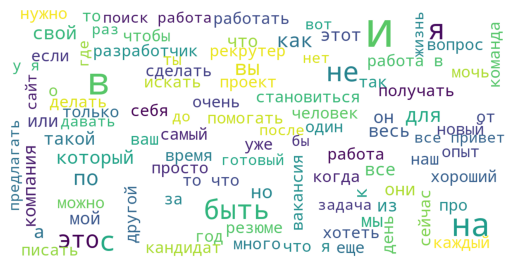

In [33]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=SEED).generate(' '.join(lemmatized_texts))
plt.axis('off')
plt.imshow(wordcloud)

## Моделирование

Стоп слова

In [35]:
Stop_Words = list(set(stopwords.words('russian')))
#print(stop_words)

In [37]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)

In [38]:
X = tfidf.fit_transform(lemmatized_texts)
X

<794x610 sparse matrix of type '<class 'numpy.float64'>'
	with 17006 stored elements in Compressed Sparse Row format>

In [40]:
text_df = pd.DataFrame.sparse.from_spmatrix(X, columns = tfidf.get_feature_names_out())
text_df

,авито,автоматизация,айти,активно,активный,актуальный,аналитик,английский,архитектура,база,...,честно,число,читать,чувствовать,школа,штат,этап,это,являться,язык
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.188932,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.150097,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.096616,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.114723,0.0,0.0
791,0.0,0.0,0.0,0.0,0.0,0.228865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
792,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## LDA

In [39]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

In [41]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(794, 10)

Ключевые слова для полученных тем

In [46]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
год, понимать, канал, ответ, оффер, знание, интервью, компания, статья, делать, смотреть, слово, задание, который, мочь, очень, тестовый, это, время, собеседование

 
Тема 2 :
понимать, любимый, ресурс, офис, язык, знать, английский, учить, отличный, сегодня, человек, хотеть, попадать, следующий, получать, проходить, значок, проверка, тест, навык

 
Тема 3 :
предлагать, весь, создание, бесплатный, самый, хороший, работа, это, обо, дизайн, рекомендовать, год, лента, конец, каждый, день, выбирать, таки, немного, успех

 
Тема 4 :
хороший, искать, поиск, привет, наш, работать, день, резюме, компания, разработчик, опыт, весь, проект, год, команда, который, свой, вакансия, работа, это

 
Тема 5 :
продолжать, подписываться, телегр, проблема, корпоративный, место, бояться, появляться, язык, показывать, куча, название, потратить, программист, рассказывать, бесплатный, пример, текущий, вакансия, факт

 
Тема 6 :
некоторый, бывать, россия, менее, зп, информация, почему, случай, лайк, би

Типичные тексты

In [56]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i+1)
    #print(developer_df.iloc[doc_id]["posts"])
    print(all_texts_cleaned[doc_id])
    print("\n")

Тема  1
использую когда она называлась еще и для меня трекпад и рабочие столы были киллер фичами смахнул влево браузер вправо документы недавно я узнал про утилиту менеджера окон для и понял что рабочие столы и тем более многозадачность в последней версии полный отстой используя я могу открывать все приложения сразу на весь экран переключаться между ними горячими клавишами у меня это не тратить время на дурацкую анимацию переключения между рабочими столами делить окна в разных пропорциях увеличивать и уменьшать переключать фокус между внешним монитором и переносить приложения на внешний монитор и мои кейсы использования переключаюсь между кодом и браузером если работаю без монитора делю экран на части где занимает браузер блокнот


Тема  2
я только что получил а значок за навык разработка клиентской стороны кто хочет быть следующим пройдите тест на проверку навыков


Тема  3
добрый день девочки как вам мой аутфит или образы для работы из дома на карантине подписывайтесь заметки для каж